<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/notebooks/aula_3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 5

Essa aula faz parte do módulo 3 sobre séries temporais do bootcamp de DataSciance aplicada da Alura. Aqui vamos trabalhar com o fbprophet tratando **outliers e validação do modelo**. Os dados trabalhados durante todo o módulo serão dados públicos do [governo de São Paulo](https://www.seade.gov.br/coronavirus/) sobre os **casos de corona vírus**. Os dados já foram retirados do site e disponibilizados pelo github da Alura no dia 18/05/2021, [neste repositório](https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip).

Os dados usados nesta aula são somente da cidade de São Paulo, [deste repositório](https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/data/out_dados_sp.csv).

## Preparando o ambiente

In [1]:
# obtendo os dados

import pandas as pd

url = 'https://github.com/matheus97eng/Bootcamp_Alura_2021/raw/main/modulo-3/aulas/data/out_dados_sp.csv'
dados_sp = pd.read_csv(url, index_col=0)
dados_sp.head()

,index,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem,taxa_de_crescimento_casos,taxa_de_crescimento_obitos,ano,media_movel_casos,media_movel_obitos
0,562,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,NaN,NaN,2020,NaN,NaN
1,1207,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
2,1852,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
3,2497,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,1.0,0.0,2020,NaN,NaN
4,3142,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,-1.0,0.0,2020,NaN,NaN


In [2]:
# vamos retirar a coluna "index":

dados_sp.drop('index', axis=1, inplace=True)

In [3]:
# convertendo a coluna "datahora" em um time series:

dados_sp['datahora'] = pd.to_datetime(dados_sp['datahora'], format='%Y-%m-%d')
dados_sp['datahora']

0     2020-02-25
1     2020-02-26
2     2020-02-27
3     2020-02-28
4     2020-02-29
         ...    
438   2021-05-08
439   2021-05-09
440   2021-05-10
441   2021-05-11
442   2021-05-12
Name: datahora, Length: 443, dtype: datetime64[ns]

In [4]:
# obtendo os registros corrigidos dos feriados de SP:

url_feriados = 'https://github.com/matheus97eng/Bootcamp_Alura_2021/raw/main/modulo-3/aulas/data/out_feriados_corrigidos.csv'
feriados_corrigidos = pd.read_csv(url_feriados, index_col=0)

feriados_corrigidos.head()

,holiday,ds
0,sp_2020,2020-02-26
1,sp_2020,2020-02-27
2,sp_2020,2020-04-11
3,sp_2020,2020-04-22
4,sp_2020,2020-05-02


### Funções úteis

Muitos comandos serão repetidos durante as aulas, por isso vamos criar funções para economizar linhas de código:

+ `split_test_train` separa os dataframes df_train e df_test de acordo com 2 parâmetros, period, que conta quantos dias deixaremos para realizar o teste, e percent_test, recebe a porcentagem dos dados que queremos deixar para teste. Só é necessário informar um desses parâmetros. Se for informado a porcentagem, o período não será levado em conta.

+ `make_prediction` recebe um modelo instanciado do fbprophet, além dos dataframes de teste e treino. Ele faz o fit do modelo e e retorna o daframe de previsão (`forecast`) de acordo com os dias que foram passados para o dataframe de teste.

In [5]:
from fbprophet import Prophet

def split_train_test(data, ds='datahora', y='casos_novos', period=30, percent_test=None):

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()
  
  if percent_test == None:
    x = data.shape[0] - period
  else:
    x = int(data.shape[0] * (1-percent_test))

  df_train['ds'] = data[ds][:x]
  df_train['y'] = data[y][:x]
  df_test['ds'] = data[ds][x:]
  df_test['y'] = data[y][x:]

  return df_train, df_test

def make_prediction(model, df_train, df_test, cap=None):

  model.fit(df_train)
  df_future = model.make_future_dataframe(periods=df_test.shape[0])
  if cap != None:
    df_future['cap'] = cap
  forecast = model.predict(df_future)
  return forecast

In [6]:
# preparando o modelo prophet como feito na aula anterior

modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, seasonality_mode='multiplicative')

df_train, df_test = split_train_test(dados_sp, period=43)
previsao = make_prediction(modelo_feriados, df_train, df_test)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Tratando outliers

Como visto nas aulas anteriores, os números de casos de covid possuem alguns pontos que realmente não se encaixam aos padrão dos dados no geral. Esses são candidatos a outliers. Mas para definir o que é um outliers é necessário entender o modelo de negócio que estamos tratando. Não há uma regra geral para definir quais serão esses pontos nem mesmo um padrão que determina o que se deve fazer com eles.

Aqui, vamos considerar outliers todos os pontos que não se ajustaram ao último modelo criado na célula de código acima, todos os que não ficaram no intervalo de confiança gerado pelo fbprophet. Para isso vamos gerar um novo dataframe que não possui esses pontos e rodar novamente o modelo para esse dataframe.

A condição que queremos é um dataframe cuja os valores da coluna "y" estejam no intervalo > `yhat_lower` e < `yhat_upper`

In [7]:
sem_outliers = df_train[(df_train['y'] > previsao['yhat_lower'][:400]) & (df_train['y'] < previsao['yhat_upper'][:400])]
sem_outliers.head()

,ds,y
0,2020-02-25,0
1,2020-02-26,0
2,2020-02-27,0
3,2020-02-28,1
4,2020-02-29,0


Vamos agora visualizar como esses dados estão distribuídos.

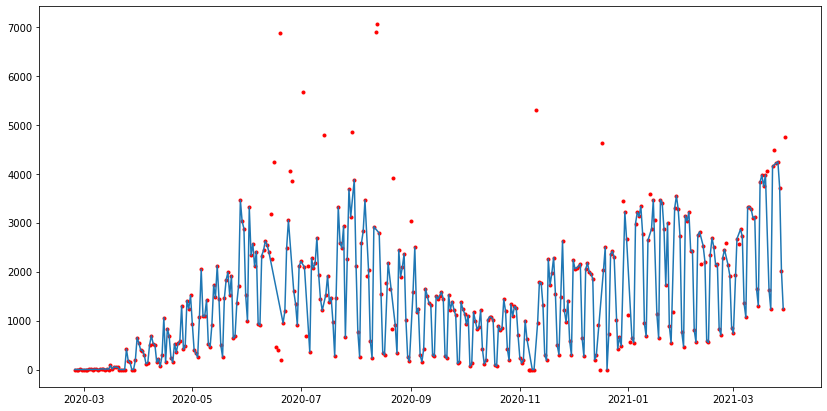

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (14,7)
plt.plot(df_train['ds'], df_train['y'], 'r.')
plt.plot(sem_outliers['ds'], sem_outliers['y'])

Os pontos vermelhos representam todos os dados originais que vieram de `dados_sp`. Já a linha azul representa a curva gerada pelos dados sem outliers.

Agora vamos rodar o mesmo modelo "modelo_feriados" nesse dataframe `sem_outliers`. Mas aqui vamos fazer `periods = 0`, para visualizar somente a parte de treino.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


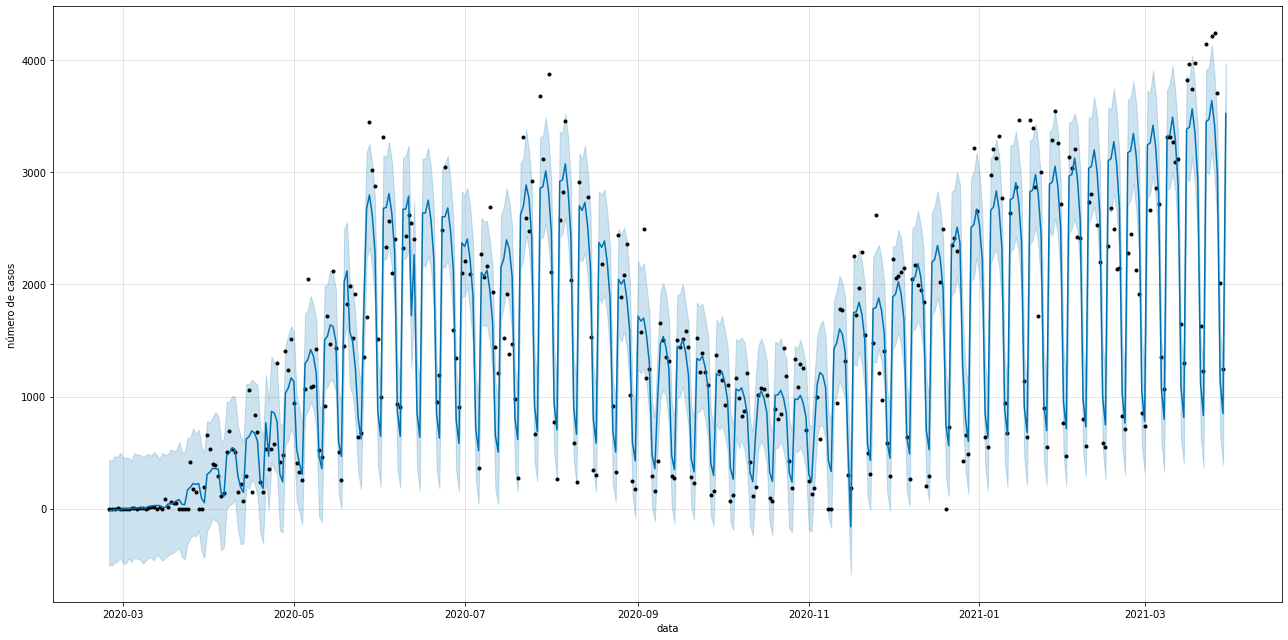

In [9]:
modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, seasonality_mode='multiplicative')
modelo_feriados.fit(sem_outliers)
previsao = modelo_feriados.predict(df_train)

fig = modelo_feriados.plot(previsao, xlabel='data', ylabel='número de casos', figsize=(18,9))

Agora vemos nos pontos pretos somente os dados tratados, retirando os outliers. Mas nesse gráfico percebemos que ainda há alguns pontos que estão fora do intervalo de confiança. Isso acontece porque rodamos um outro modelo no prophet, ajustado com outros dados. Por isso, foram gerados uma nova curva de tendência e um novo intervalo de confiança.

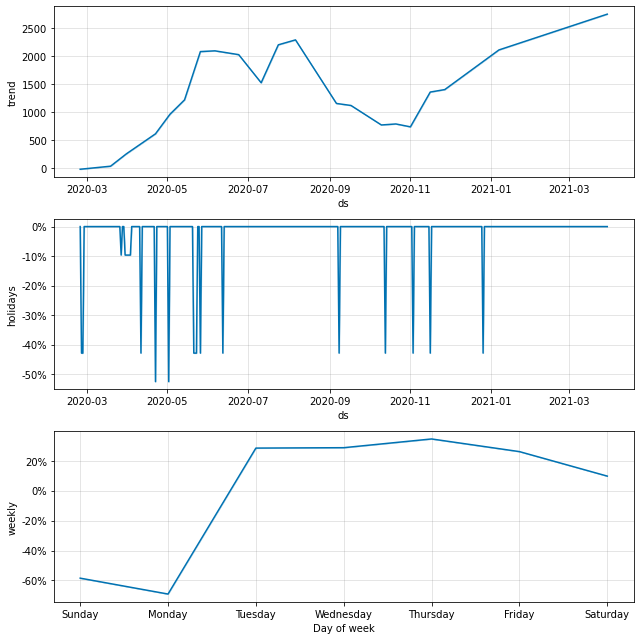

In [10]:
# plotando os componentes da curva ajustada:

modelo_feriados.plot_components(previsao);

agora vamos rodar o modelo mostrando também o período de 43 dias do dataframe df_test

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


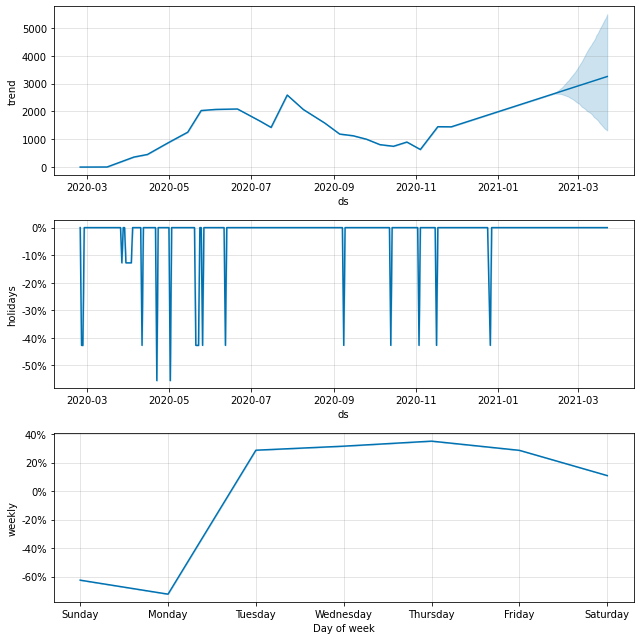

In [11]:
df_train, df_test = split_train_test(sem_outliers, ds='ds', y='y', period=43)
modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, seasonality_mode='multiplicative')
previsao = make_prediction(modelo_feriados, df_train, df_test)
modelo_feriados.plot_components(previsao);

Agora percebemos, no gráfico de tendência, um intervalo de confiança crescente para os dias do dataframe de teste. Isso significa que a região do intervalo de confiança da curva ajustada do modelo vai ir aumentando.

Vemos isso acontecer porque para calcular os parâmetros da curva de tendência, o prophet "chuta" vários coeficientes que se adequam aos dados de treino. Esses diferentes coeficientes irão fornecer diferentes curvas para o período de 43 dias de teste.

Essas várias soluções são registradas pelo prophet e podem ser vistas pelo método `predictive_samples`. Vamos coletar as soluções para a curva de tendência e plotá-las usando matplotlib.

foram analisadas 356 possíveis soluções diferentes


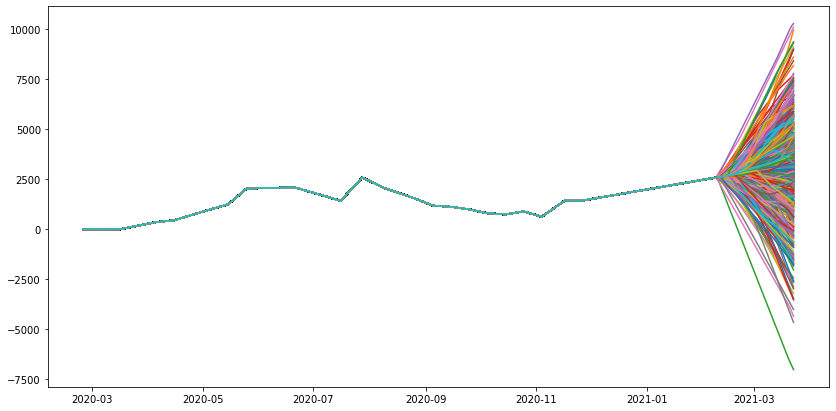

In [12]:
amostras = modelo_feriados.predictive_samples(previsao)
plt.plot(previsao['ds'], amostras['trend']);
tamanho = len(amostras['trend'])
print(f'foram analisadas {tamanho} possíveis soluções diferentes')

## Cross validation

Vamos agora utilizar uma técnica para avaliar nosso modelo chamada cross validation. Ela fornece uma vantagem em relação a uma validação simples (técnica de holdout), que separa os dados em apenas 2 grupos: treino e teste. Já a validação cruzada do fbprophet separa os dados em 3 tipos: treino, validação e teste. O treino é usado para aplicar o modelo. A validação é usada para calcular a performance do modelo. Por fim, o teste é usado para calcular a métrica final de teste do modelo.

Mas a separação do cross validation não se resume a 3 grupos simples. Essa técnica separa vários grupos e cada grupo possui a sua própria separação de treino e teste dos dados. No fbprophet, há um parâmetro `initial`, que determina o tamanho do primeiro "pedaço" usado para treino. Outro parâmetro é `period`, que determina qual será o tamanho dos espaços que serão acrescentados nos grupos para os dados de treino. Assim, a cada novo grupo, o tamanho dos dados de treino será o tamanho dos dados de treino do grupo anterior mais o tamanho de `periods`. Por fim temos o parâmetro `horizon`, que define o tamanho dos dados de teste para todos os grupos.

Vamos rodar essa funcionalidade do prophet testando para alguns valores dos parâmetros.

In [13]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(modelo_feriados, initial='180 days', period='30 days', horizon='30 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-09-11 00:00:00 and 2021-01-09 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-12,987.002998,648.700429,1363.473657,1316,2020-09-11
1,2020-09-13,387.726696,17.260995,761.156200,294,2020-09-11
2,2020-09-14,267.808765,-125.298551,660.594735,273,2020-09-11
3,2020-09-15,1018.743089,593.106508,1417.414819,1501,2020-09-11
4,2020-09-16,1001.565467,539.871891,1421.833935,1442,2020-09-11


Como o prophet informa, foram feitos 5 forecasts, ou seja, 5 previsões diferentes, o que consequentemente implica em 5 grupos de divisão diferentes e 5 vezes que foi rodado o modelo.

A função `cross_validation` como pode ser visto acima retorna um dataframe contendo as informações de `ds`, `yhat` (a previsão), `yhat_lower`, `yhat_upper`, `y`, que são os dados originais e `cutoff`. Essa última informação é a data a partir do qual o dados começam a ser usados como teste. A cada grupo, esse cutoff vai mudar. Então a coluna `cutoff` irá conter todas as datas a partir das quais foram feitos os testes.

In [14]:
df_cv['cutoff'].unique()

array(['2020-09-11T00:00:00.000000000', '2020-10-11T00:00:00.000000000',
       '2020-11-10T00:00:00.000000000', '2020-12-10T00:00:00.000000000',
       '2021-01-09T00:00:00.000000000'], dtype='datetime64[ns]')

O que queremos agora é analisar por meio de gráficos cada modelo que o prophet aplicou. Para isso vamos definir "janelas", onde cada janela representará uma parte diferente dos dados sendo usada para teste.

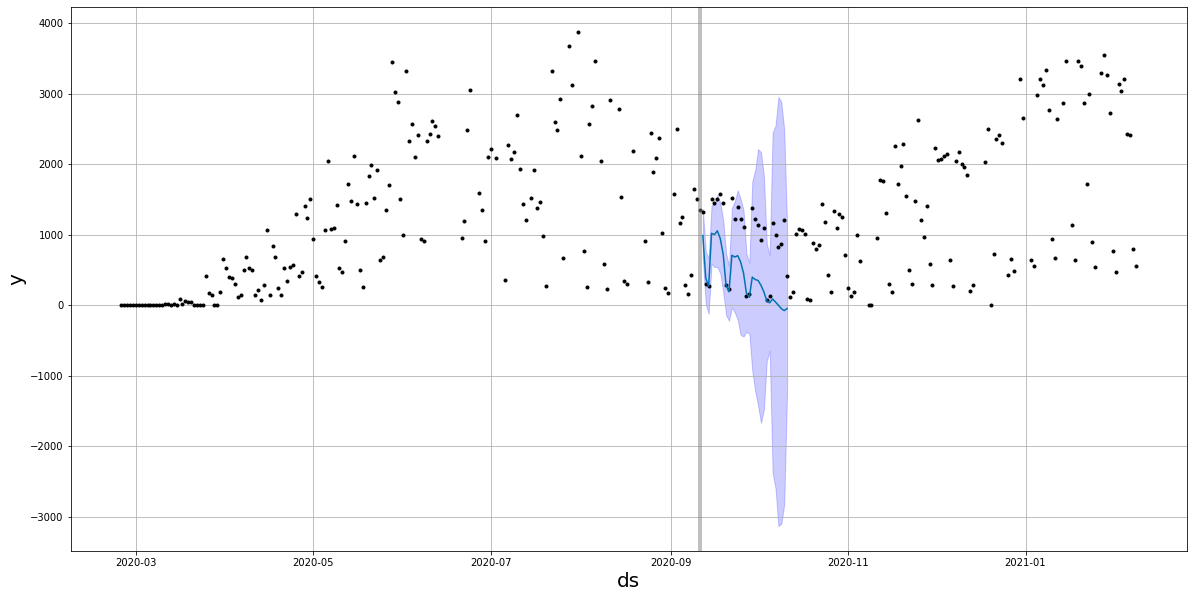

In [15]:
janela = 0

cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(modelo_feriados.history['ds'].values, modelo_feriados.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue', alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y', size=20)
ax.set_xlabel('ds', size=20)
plt.grid()

O mesmo resultado pode ser obtido com o comando abaixo:

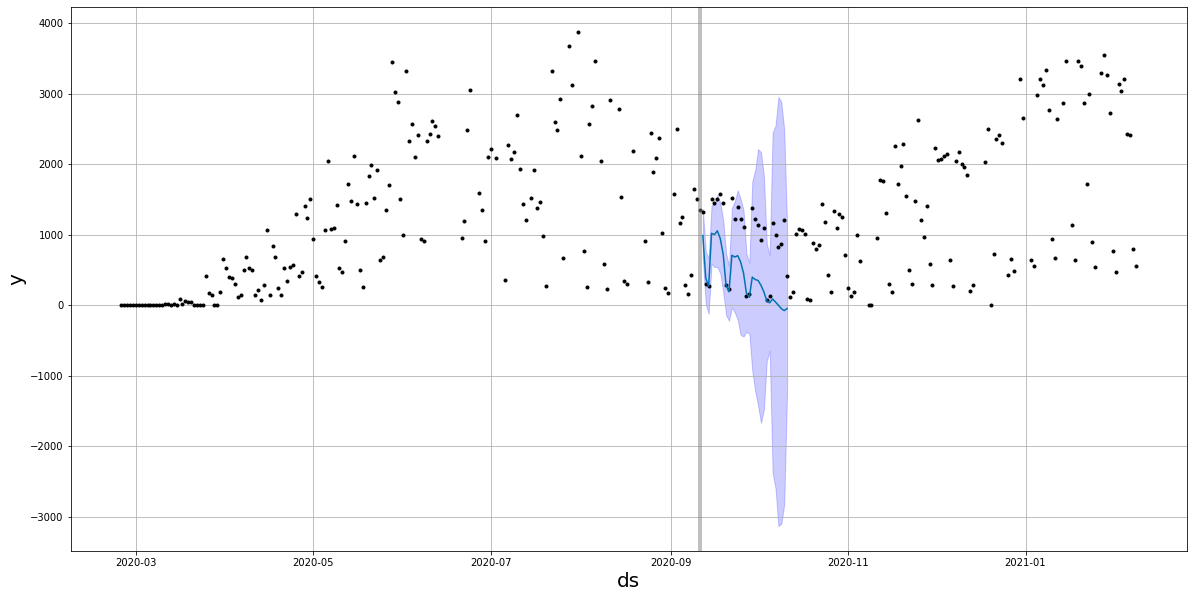

In [16]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(df_train['ds'], df_train['y'], 'k.')
ax.plot(df_cv_cut['ds'], df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'], df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue', alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y', size=20)
ax.set_xlabel('ds', size=20)
plt.grid()

e ainda podemos rodar para todas as 5 janelas:

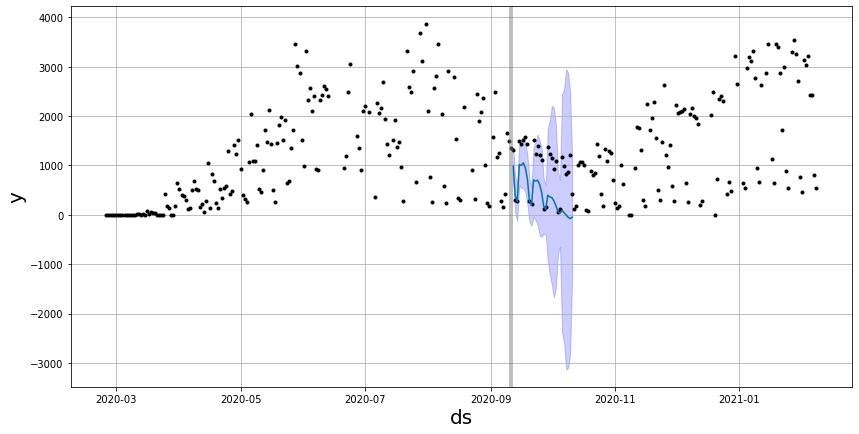

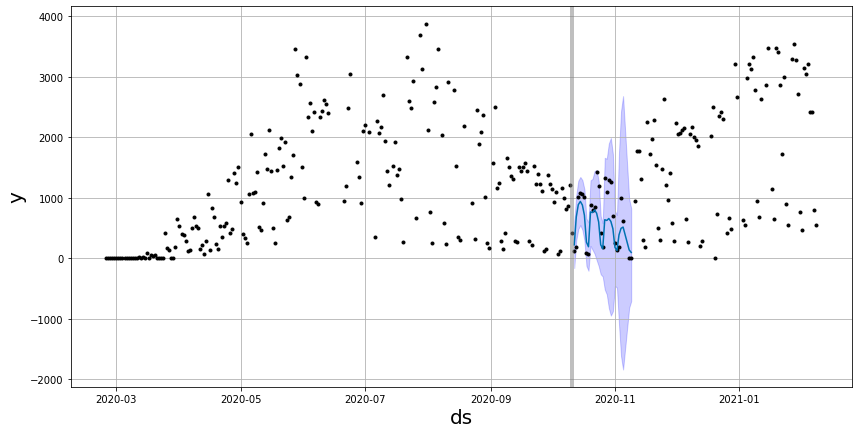

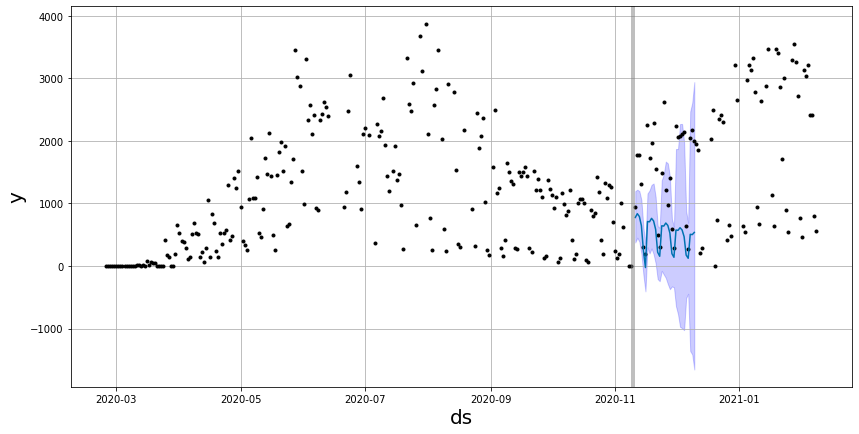

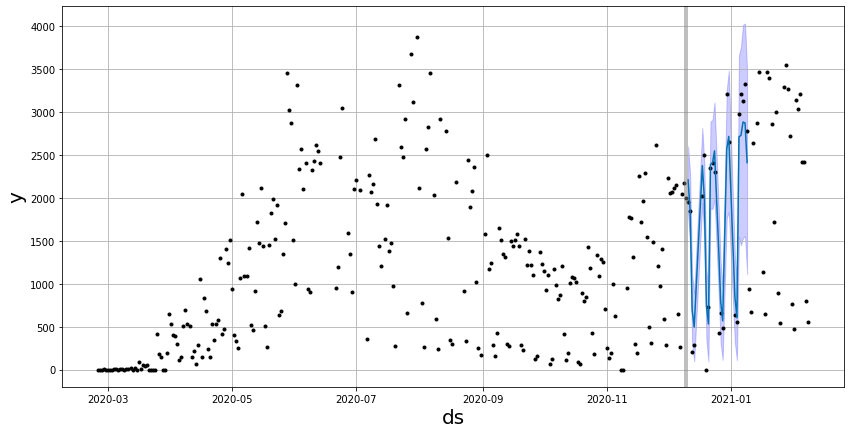

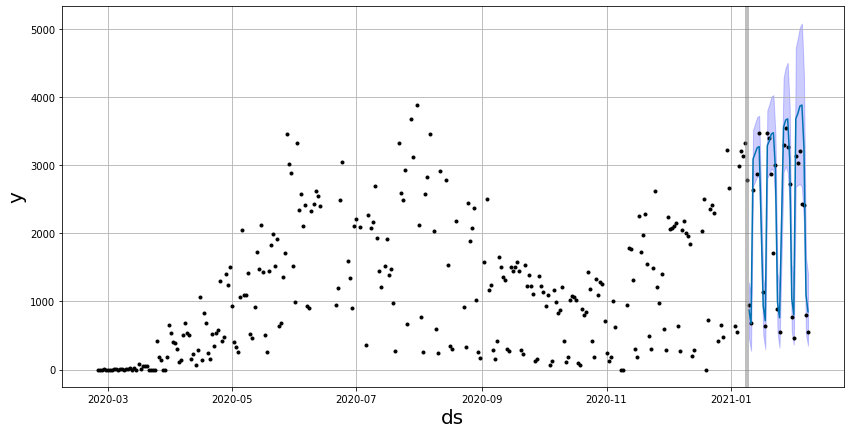

In [17]:
for janela in range(0,5):

  cutoff = df_cv['cutoff'].unique()[janela]
  df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]

  fig = plt.figure(figsize=(14,7))
  ax = fig.add_subplot(111)
  ax.plot(modelo_feriados.history['ds'].values, modelo_feriados.history['y'], 'k.')
  ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
  ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                  df_cv_cut['yhat_upper'], color='blue', alpha=0.2)
  ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
  ax.set_ylabel('y', size=20)
  ax.set_xlabel('ds', size=20)
  plt.grid()

### Métricas  de performance do modelo

Falta ainda analisar as métricas que avaliam o quão bom é o nosso modelo. O fbprophet já calcula várias dessas métricas através de `performance_metrics`. Vamos salvar os dados obtidos em um dataframe.

In [18]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,206539.481108,454.466150,319.657550,0.170658,0.615385
1,4 days,235716.475515,485.506411,367.529114,0.321290,0.492308
2,5 days,194799.188680,441.360611,354.662376,0.192160,0.538462
3,6 days,137100.803491,370.271257,318.003772,0.301693,0.723077
4,7 days,304142.845114,551.491473,410.399305,0.305433,0.692308
5,8 days,387654.960567,622.619435,477.955423,0.402802,0.673077
6,9 days,484072.376505,695.753100,514.370496,0.402802,0.538462
7,10 days,447573.328954,669.009214,456.726297,0.184629,0.600000
8,11 days,440054.118430,663.365750,445.575917,0.168508,0.600000
9,12 days,357790.863964,598.156220,442.320147,0.272405,0.676923


Nesse dataframe, a coluna `horizon` significa qual o dia sendo analisada a previsão do modelo. A partir daí temos as métricas:

+ MSE - Mean Square Error, ou erro quadrático médio
+ RMSE - Root Mean Square Error, ou raíz do erro quadrático médio
+ MAE - Mean Absolute Error, ou erro médio absoluto
+ MAPE - Mean Absolute Percentual Error, ou erro absoluto médio percentual

Podemos ver essas métricas por meio de gráficos também. Vamos olhar para o RMSE.

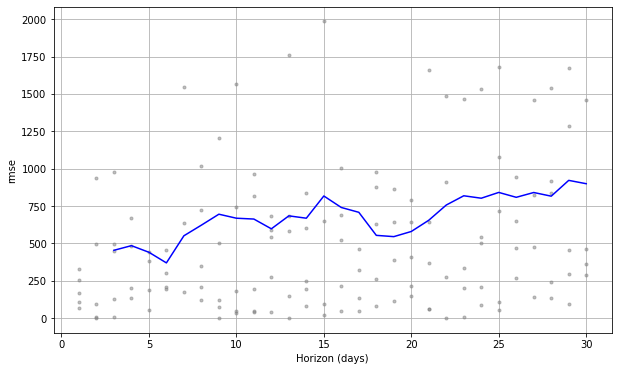

In [19]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='rmse');

Cada ponto cinza no gráfico significa a métrica sendo aplicada a um grupo diferente de janela (0, 1, 2, 3 ou 4), para diferentes dias de previsão (horizon). A curva azul é a média desses valores calculados. É interessante perceber que quanto mais longe é o dia da previsão, mais difícil costuma ser prever algo e por conta disso as métricas vão ficando um pouco mais piores.

## Desafios:

Desafio 13: Testar diferentes intervalos de confiança.

Desafio 14: Buscar quais métricas se aplicam a quais casos.

### Desafio 13: Testar diferentes intervalos de confiança.

Essa parte é muito fácil de se fazer no facebook prophet. Basta alterarmos o parâmetro `interval_width`. Ele nos permite escolher qual será o tamanho do intervalo de confiança calculado. Por padrão ele está em 80%. Vamos alterá-lo para ver a diferença no gráfico.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


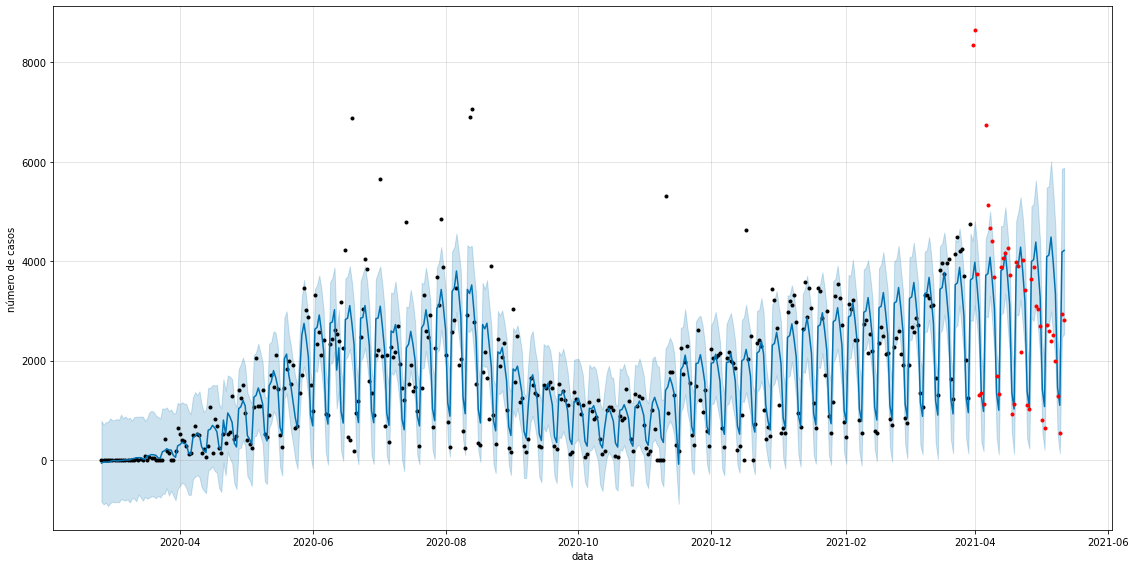

In [20]:
df_train, df_test = split_train_test(dados_sp, period=43)
modelo_75 = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, 
                    seasonality_mode='multiplicative', interval_width=0.75)
previsao_75 = make_prediction(modelo_75, df_train, df_test)

fig = modelo_75.plot(previsao_75, xlabel='data', ylabel='número de casos', figsize=(16,8))
plt.plot(df_test['ds'], df_test['y'], 'r.')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


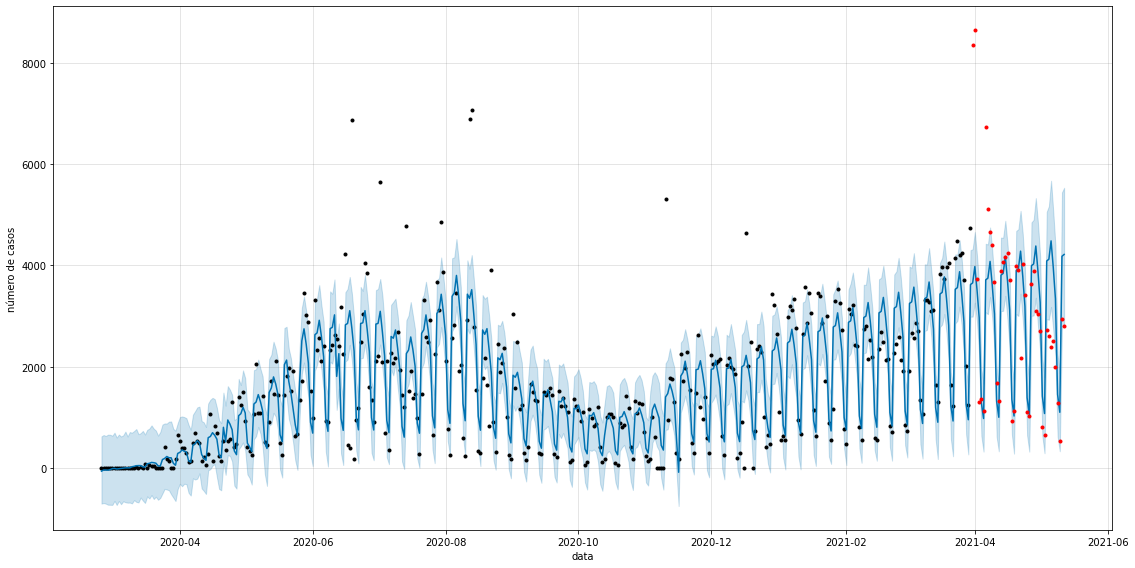

In [21]:
df_train, df_test = split_train_test(dados_sp, period=43)
modelo_65 = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, 
                    seasonality_mode='multiplicative', interval_width=0.65)
previsao_65 = make_prediction(modelo_65, df_train, df_test)

fig = modelo_65.plot(previsao_65, xlabel='data', ylabel='número de casos', figsize=(16,8))
plt.plot(df_test['ds'], df_test['y'], 'r.')

agora vamos ver se esse intervalo de confiança realmente influencia nos nossos dados, quando usamos ele para definir o que são outliers.

In [22]:
cut_75 = df_train[(df_train['y'] > previsao_75.loc[:399,'yhat_upper']) | (df_train['y'] < previsao_75.loc[:399,'yhat_lower'])]
cut_65 = df_train[(df_train['y'] > previsao_65.loc[:399,'yhat_upper']) | (df_train['y'] < previsao_65.loc[:399,'yhat_lower'])]
print(len(cut_75), 'dos dados estão fora do intervalo de confiança de 75% e ', len(cut_65), 'estão fora do intervalo de confiança de 65%')

59 dos dados estão fora do intervalo de confiança de 75% e  88 estão fora do intervalo de confiança de 65%


Percebemos que alterar o intervalo de confiança em apenas 10% altera em muito os dados que serão considerados outliers. Naturalmente, essa diferença ficará cada vez maior a medida que diminuimos mais ainda o intervalo de confiança.

É importante também dizer que os parâmetros `changepoints_prior_scale` e `uncertanly_samples` (quantidade de amostras que serão usadas para calcular as incertezas) também alteram o intervalo da confiança e portanto podem interferir no número de outliers que encontraremos.

### Desafio 14: Buscar quais métricas se aplicam a quais casos.

> #### MSE - erro quadrático médio

Calcula o quadrado da diferença entre o valor real e o valor calculado pelo modelo. Ao final os quadrados são somados e divididos pelo número de amostras. Como a diferença é elevada ao quadrado, a unidade de medida do erro também deverá ser dada ao quadro. No nosso caso, o valor seria contado em número de casos ao quadrado, o que não faz sentido. Também por conta das diferenças serem elevadas ao quadrado, o erro quadrático médio é mais sensível a valores discrepantes, possíveis candidatos a outliers.

> #### RMSE - raíz do erro quadrático médio

Tem o mesmo conceito do erro quadrático médio, mas para resolver o problema da dimensão ao quadrado, é extraído no final a raíz. Assim como o MSE, quanto mais próximo de zero, mais próxima a previsão estará dos dados originais.

> #### MAE - erro médio absoluto

Calcula o módulo das diferenças entre os valores dos dados originais e os previstos. Ao final, é feita a média desses módulos. Novamente, quanto mais próximo de zero, mais próxima a previsão estará dos dados originais.

O módulo nos cáculos existe para não dar a falsa impressão causada quando erros negativos e positivos se somam e reduzem a média. Assim, teremos uma noção real do quanto os dados previstos se afastam, **em média**, dos dados reais.

> #### MDAPE - median absolute percent error, ou mediana dos erros percentuais absolutos

Para cada ds, calcula a diferença entre o dado real e o de previsão e divide essa diferença pelo valor real. Assim, temos uma ideia do tamanho que o erro representa em relação ao tamanho do dado real, sendo o valor visto como uma porcentagem. Por fim, o MDAPE calcula a mediana de todas essas porcentagens.

> #### Coverage, ou cobertura 

É a porcentagem de dados que se encontram no intervalo de confiança calculado pelo prophet. Quanto mais próximo de 1, significa que o modelo se encaixa melhor os dados. Não necessariamente significa que o modelo é melhor, somente que o intervalo de confiança está abrangendo melhor os dados. No nosso caso aqui quando medimos essa métrica com o cross validation, as previsões com mais dias (horizon com valor maior) teve uma cobertura mais próxima de 1 porque o intervalo de confiança era maior para essas previsões.